##  OpenCV vs. scikit-image performance intercomparison for deshaking timelapse sequences using Python 

### Note

This is a pre-study for the early development phase of pylapsy. It basically investigates the question, whether `pylapsy` should be based on `OpenCV` library or whether it should use the more pure Python library of `scikit-image` for the basic image processing. I use the example of *deshaking* of an image sequence using two frames. The analysis is done both for low and high resolution versions of the images (i.e. ~400 pix and ~ 4000 pix, long edge. 

### Why doing this?

I took inspiration from the python [deshake](https://github.com/pmoret/deshake) project, which is essentially a simple python script with a small command line interface, that can be used to deshake a timelapse sequence. I have used it quite often recently and it works pretty well. However, I found it quite slow (even though it is parallelised): it often takes several hours (sometimes even a whole night) on my laptop to deshake a timelapse sequence. I thought, this should be possible in a faster way and from my previous experience, I knew that it would likely be considerably faster by using `OpenCV` instead of `scikit-image`. Below, you find my results.

### Quick answer:

OpenCV is about an order of magnitude faster, but requires more fundamental understanding of what it takes to perform this task. Personally I prefer OpenCV, not only because it is faster, but also because it helps for understanding better, what is going on behind the scenes.

### Stuff we need

In [10]:
import glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import skimage as ski
from skimage.feature import register_translation
import cv2

RERUN_PERFORMANCE_TEST = False

### Versions used of OpenCV and scikit-image

In [2]:
cv2.__version__

'4.1.0'

In [3]:
ski.__version__

'0.15.0'

In [4]:
str(datetime.now())

'2019-05-30 11:54:39.632401'

### Definition of helper methods used in this notebook

Not so relevant, method names should be self-explanatory.

In [5]:
def _disp_image(img, ax, **kwargs):
    try:
        cmap = kwargs.pop('cmap')
    except:
        cmap = None
    if not isinstance(img, np.ndarray):
        raise ValueError('Invalid input: need numpy array...')
    elif not img.ndim in (2, 3):
        raise ValueError('Invalid image dimension, can only handle 2D or 3D arrays')
    if img.ndim == 2 and cmap is None:
        cmap = 'gray'
    
    ax.imshow(img, cmap=cmap, **kwargs)
    return ax

def disp_compare(cv, ski, test_name, figsize=(18, 6)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1 = _disp_image(cv, ax=ax1)
    ax1.set_title('OpenCV Ndim={}, dtype={}, min/max = ({:.1f}, {:.1f})'
                  .format(cv.ndim, cv.dtype, cv.min(), cv.max()))
    
    ax2 = _disp_image(ski, ax=ax2)
    ax2.set_title('skimage Ndim={}, dtype={}, min/max = ({:.1f}, {:.1f})'
                  .format(ski.ndim, ski.dtype, ski.min(), ski.max()))
    fig.suptitle(test_name, fontsize=18)

    return (ax1, ax2)
    
def disp_two(img1, img2, cmap='gray', **kwargs):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6))
    ax1.imshow(img1, cmap=cmap, **kwargs)
    ax2.imshow(img2, cmap=cmap, **kwargs)
    return (ax1, ax2)

def measure_performance(fun, *input_args):
    res = %timeit -o fun(*input_args)
    return res

## Define methods compared in this notbebook

See [here](https://www.learnopencv.com/video-stabilization-using-point-feature-matching-in-opencv/) for opencv related info.

In [6]:
# Read image
read_ski = lambda file : ski.io.imread(file)
read_cv = lambda file : cv2.imread(file)#opencv loads BGR as default

# Convert to gray-scale
to_gray_ski = lambda rgb : ski.color.rgb2gray(rgb)
to_gray_cv = lambda rgb : cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)

# Detect edges (Sobel filter)
def apply_sobel_cv(gray_cv, **kwargs):
    hor = np.uint8(np.abs(cv2.Sobel(gray_cv, cv2.CV_64F, 1, 0, **kwargs)))
    vert = np.uint8(np.abs(cv2.Sobel(gray_cv, cv2.CV_64F, 0, 1, **kwargs))) #, ksize=5)
    return cv2.bitwise_or(hor, vert)

apply_sobel_ski = lambda gray : ski.filters.sobel(gray)

# Find shift between 2 images (deshaking)
## OpenCV
def _compute_flow_lk(first_gray, second_gray, **feature_lk_params):
    feature_params = dict(maxCorners = 100,
                          qualityLevel = 0.3,
                          minDistance = 7,
                          blockSize = 7)
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    for k, v in feature_lk_params.items():
        if k in feature_params:
            feature_params[k] = v
        if k in lk_params:
            lk_params[k] = v
     
    p0 = cv2.goodFeaturesToTrack(first_gray, **feature_params)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(first_gray, second_gray, p0, None, **lk_params)
    
    # Sanity check
    assert p0.shape == p1.shape 
    
    # Filter only valid point
    # Select good points
    return (p0[st==1], p1[st==1])
    
def find_affine_partial2d_cv(good_this=None, good_next=None, **flowlk_kwargs):
    if good_this is None:
        good_this, good_next = _compute_flow_lk(**flowlk_kwargs)
    
    #Find transformation matrix
    return cv2.estimateAffinePartial2D(good_this, good_next)[0]
    
def find_homography_cv(good_this=None, good_next=None, **flowlk_kwargs):
    if good_this is None:
        good_this, good_next = _compute_flow_lk(**flowlk_kwargs)
    
    return cv2.findHomography(good_this, good_next)[0]

def find_shift_cv(first_gray, second_gray, **feature_lk_params):
    good_this, good_next = _compute_flow_lk(first_gray, second_gray, **feature_lk_params)
    
    m = find_affine_partial2d_cv(good_this, good_next)
    shift = (m[0,2], m[1,2])
    da = np.arctan2(m[1,0], m[0,0])
    return (shift, da, m)

## scikit-image
def find_shift_ski(first_gray, second_gray):
    first_edges = ski.filters.sobel(first_gray)
    second_edges =ski.filters.sobel(second_gray)
    
    shift, error, diffphase = register_translation(first_edges, second_edges, 100)
    return shift

# Shift image
def shift_image_ski(image, shift=None):
    if shift is None:
        shift = (0,0)
    dy, dx = shift
    tf_shift = ski.transform.SimilarityTransform(translation=[-dx, -dy])
    shifted = ski.transform.warp(image, tf_shift)
    return shifted

def shift_image_cv(image, m=None):
    if m is None: # no shift
        m = np.zeros((2,3))
        m[0,0] = 1
        m[1,1] = 1

    m[0,2] = -m[0,2] 
    m[1,2] = -m[1,2]
    if m.shape == (2, 3):
        shifted = cv2.warpAffine(image, m, (image.shape[1], image.shape[0]))
    elif m.shape == (3,3):
        shifted = cv2.warpPerspective(image, m, (image.shape[1], image.shape[0]))
    else:
        raise ValueError('Invalid input for transormation matrix m')
    return shifted

def crop_shift(img, shift, cv=True):
    if cv:
        dx, dy = shift
    else:
        dy, dx = -shift[0], -shift[1]
    dx = int(round(dx))
    dy = int(round(dy))
    if img.ndim==2:
        h, w = img.shape
    else:
        h, w, _ = img.shape
    x0, y0, x1, y1 = 0,0,w,h
    if dx > 0: #second frame was shifted to the left -> crop right
        x1 = -dx-1
    elif dx < 0: # second frame was shifted to the right -> crop left
        x0 = -dx+1
    if dy > 0: #second frame was shifted to the top -> crop bottom
        y1 = -dy-1
    elif dy < 0: # second frame was shifted to the right -> crop top
        y0 = -dy+1
    return img[y0:y1, x0:x1]

# Sum it up: methods that do everything from reading of both images to deshaking them
def deshake_cv(imfile1, imfile2):
    first = read_cv(imfile1)
    second = read_cv(imfile2)
    
    first_gray = to_gray_cv(first)
    second_gray = to_gray_cv(second)
    
    (shift, da, M) = find_shift_cv(first_gray, second_gray)
    shifted = shift_image_cv(second, M)
    return (crop_shift(first, shift, cv=True), crop_shift(shifted, shift, cv=True))

def deshake_ski(imfile1, imfile2):
    first = read_ski(imfile1)
    second = read_ski(imfile2)
    
    first_gray = to_gray_ski(first)
    second_gray = to_gray_ski(second)
    
    shift = find_shift_ski(first_gray, second_gray)
    shifted = shift_image_ski(second, shift)
    return (crop_shift(first, shift, cv=False), crop_shift(shifted, shift, cv=False))

## Synthetic test images

Shift detected ski: dx=5.0, dy=10.0
Shift detected cv: dx=-9.999699946648537, dy=-4.999883138141882


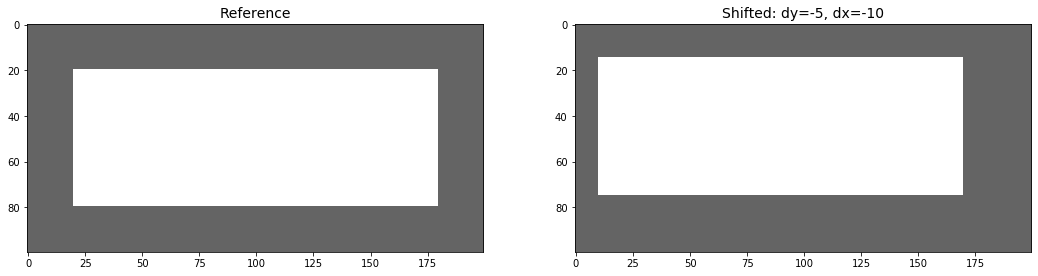

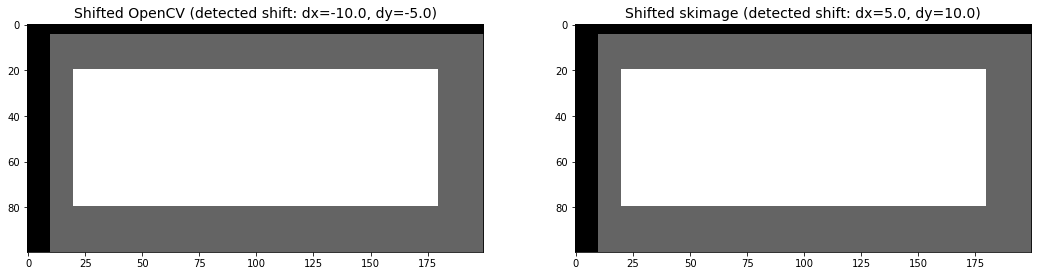

In [7]:
img1 = (np.ones((100, 200))*100).astype(np.uint8)
img1[20:-20, 20:-20] = 255

img2 = (np.ones((100, 200))*100).astype(np.uint8)
img2[15:-25, 10:-30] = 255

ax1, ax2 = disp_two(img1, img2, vmin=0, vmax=255)
ax1.set_title('Reference', fontsize=14)
ax2.set_title('Shifted: dy=-5, dx=-10', fontsize=14)

shift_ski = find_shift_ski(img1, img2)
shift_cv, _, M = find_shift_cv(img1, img2)
print('Shift detected ski: dx={}, dy={}'.format(*shift_ski))
print('Shift detected cv: dx={}, dy={}'.format(*shift_cv))

shifted_ski = shift_image_ski(img2, shift_ski)
shifted_ski = (shifted_ski*255).astype(np.uint8)
shifted_cv = shift_image_cv(img2, M)
ax1, ax2 = disp_two(shifted_cv, shifted_ski, vmin=0, vmax=255)
ax1.set_title('Shifted OpenCV (detected shift: dx={:.1f}, dy={:.1f})'.format(*shift_cv), fontsize=14)
ax2.set_title('Shifted skimage (detected shift: dx={:.1f}, dy={:.1f})'.format(*shift_ski), fontsize=14);

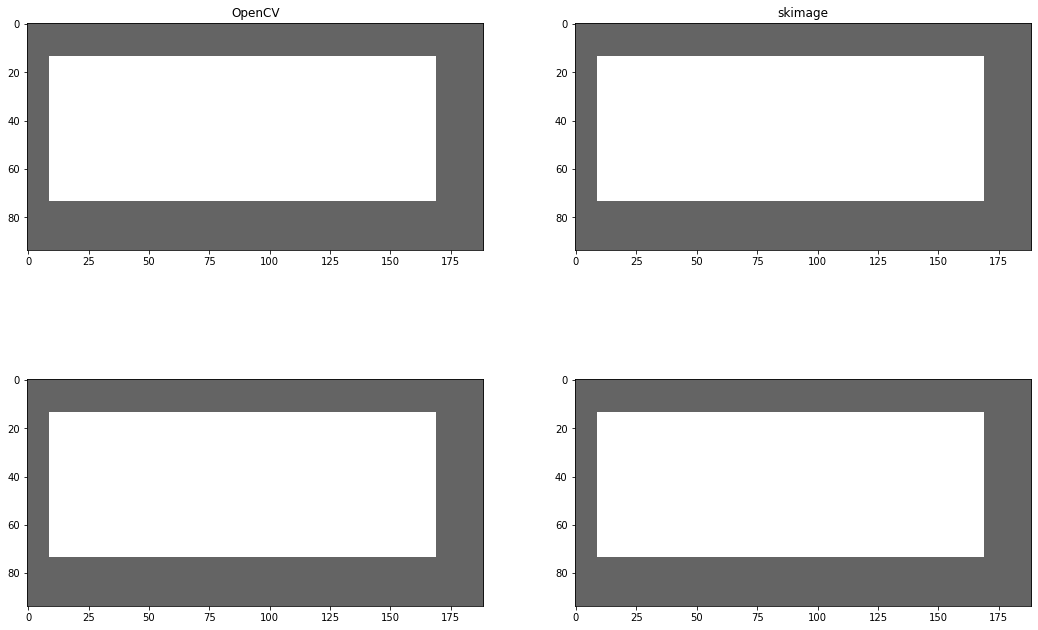

In [8]:
img1_crop_cv = crop_shift(img1, shift_cv)
shifted_cv_crop = crop_shift(shifted_cv, shift_cv)

img1_crop_ski = crop_shift(img1, shift_ski, cv=False)
shifted_ski_crop = crop_shift(shifted_ski, shift_ski, cv=False)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18, 12))
ax1.imshow(img1_crop_cv, vmin=0, vmax=255, cmap='gray')
ax1.set_title('OpenCV')
ax2.imshow(img1_crop_ski, vmin=0, vmax=255, cmap='gray')
ax2.set_title('skimage')
ax3.imshow(shifted_cv_crop, vmin=0, vmax=255, cmap='gray')
ax4.imshow(shifted_ski_crop, vmin=0, vmax=255, cmap='gray')

In [9]:
imfile1, imfile2 = glob.glob('test_images/lowres/*.jpg')
imfile3, imfile4 = glob.glob('test_images/highres/*.jpg')
imfile1, imfile2, imfile3, imfile4

('test_images/lowres\\DSC_5646.jpg',
 'test_images/lowres\\DSC_5647.jpg',
 'test_images/highres\\LRT_00010.jpg',
 'test_images/highres\\LRT_00011.jpg')

## Test the functions and display output (where applicable)

### Read

In [10]:
rgb_cv = read_cv(imfile1)
rgb_ski = read_ski(imfile1)

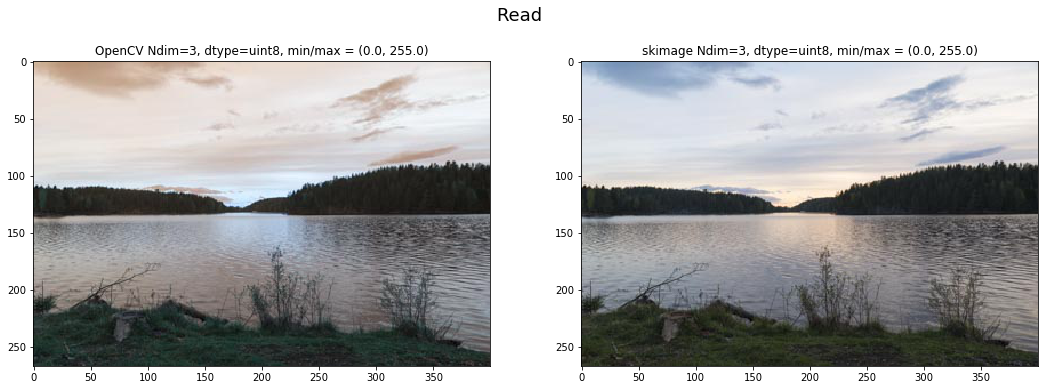

In [11]:
disp_compare(rgb_cv, rgb_ski, 'Read');

### Convert to grayscale

In [12]:
gray_cv = to_gray_cv(rgb_cv)

In [13]:
gray_ski = to_gray_ski(rgb_ski)

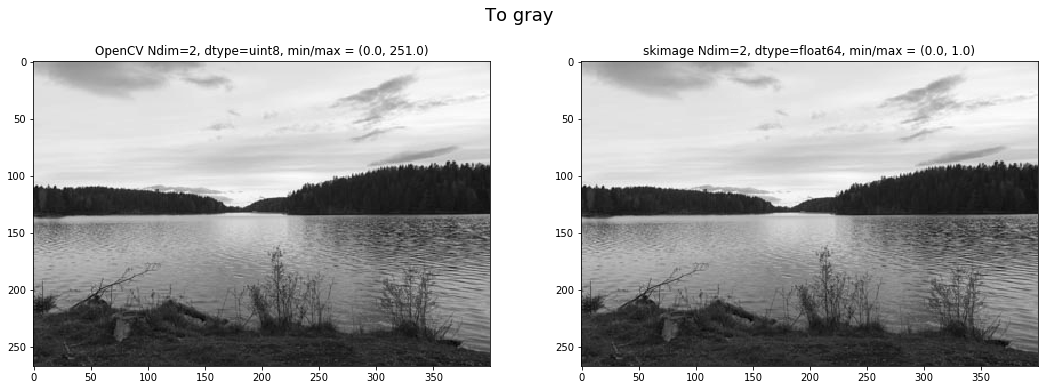

In [14]:
disp_compare(gray_cv, gray_ski, 'To gray');

### Sobel filter

In [15]:
sobel_cv = apply_sobel_cv(gray_cv)

In [16]:
sobel_ski = apply_sobel_ski(gray_ski)

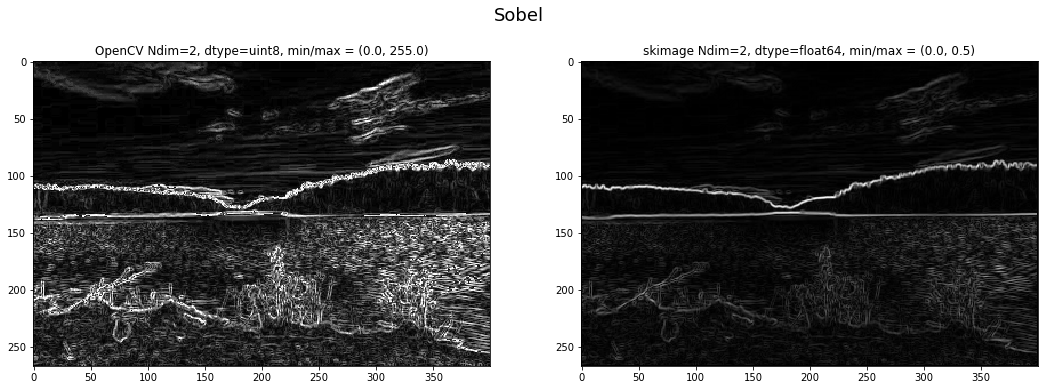

In [17]:
disp_compare(sobel_cv, sobel_ski, 'Sobel');

## Deshake 

### Find translation shift

First, load the second image

In [18]:
second_ski = read_ski(imfile2)
second_cv = read_cv(imfile2)

gray_ski_second = to_gray_ski(second_ski)
gray_cv_second = to_gray_cv(second_cv)

In [19]:
shift_ski = find_shift_ski(gray_ski, gray_ski_second)
'dy, dx = ', shift_ski

('dy, dx = ', array([-1.74,  0.03]))

In [20]:
shift_cv, da, M = find_shift_cv(gray_cv, gray_cv_second)
'dx, dy = ', shift_cv

('dx, dy = ', (-0.03125182863064781, 1.738905206697005))

### Shift second image (apply translation shift)

In [21]:
second_shifted_ski = shift_image_ski(second_ski, shift_ski)
second_shifted_ski.shape

(267, 400, 3)

In [22]:
second_shifted_cv = shift_image_cv(second_cv, M)
second_shifted_cv.shape

(267, 400, 3)

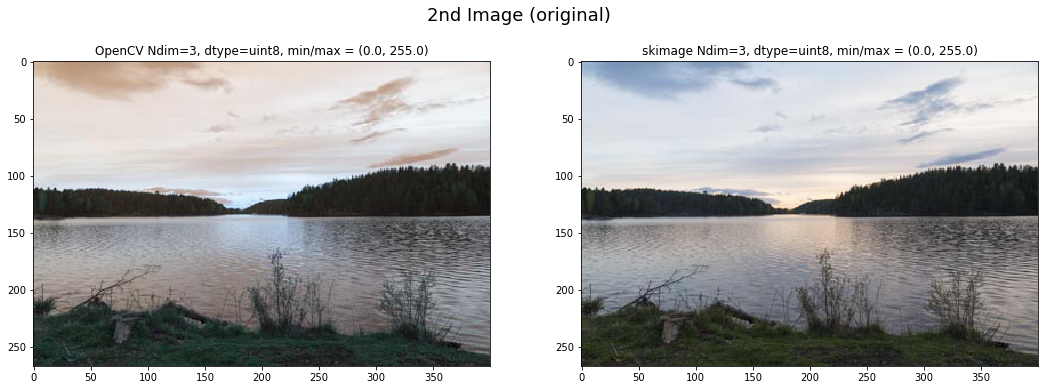

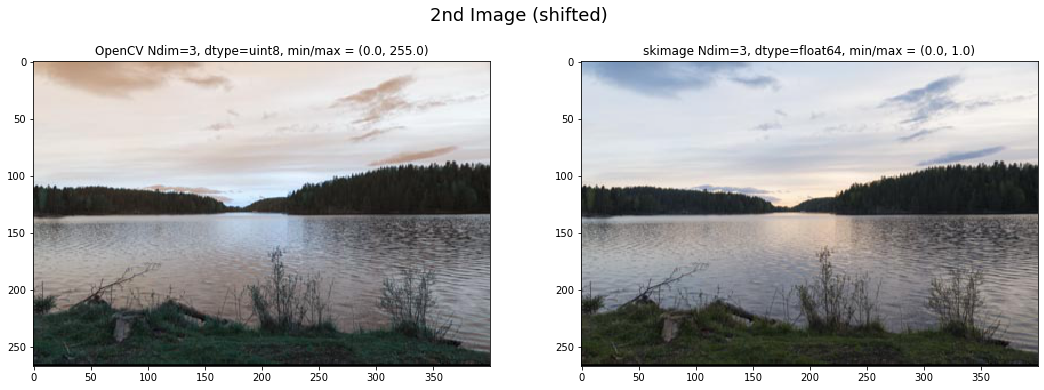

In [23]:
disp_compare(second_cv, second_ski, '2nd Image (original)');

disp_compare(second_shifted_cv, second_shifted_ski, '2nd Image (shifted)');

In [ ]:
%%timeit
from multiprocessing import Pool, cpu_count
num_cpu = cpu_count()


In [26]:
p = Pool(num_cpu)
for k in range(1):
    params = zip(num_cpu * [imfile1], num_cpu*[imfile2])
    #p.map(deshake_ski, params)
    for item in params:
        print(item)

('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/l

('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/l

('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/lowres\\DSC_5647.jpg')
('test_images/lowres\\DSC_5646.jpg', 'test_images/l

In [ ]:
second_highres_cv = read_cv(imfile4)
second_highres_ski = read_ski(imfile4)

(first_corr_cv, second_corr_cv) = deshake_cv(imfile3, imfile4)
(first_corr_ski, second_corr_ski) = deshake_ski(imfile3, imfile4)

In [ ]:
disp_compare(first_corr_cv, first_corr_ski, 'First corrected');
disp_compare(second_corr_cv, second_corr_ski, 'Second corrected');

In [ ]:
second_highres_cv.shape, second_corr_cv.shape, second_corr_ski.shape

## Performance intercomparison

Init table used to store the results of the performance comparison

In [ ]:
results = [] 

def _append_result(results, res_cv, res_ski, test_name):
    diff_percent = (res_ski.average - res_cv.average) / res_cv.average * 100
    results.append([test_name, res_cv.average*1000, res_ski.average*1000, diff_percent])
    return results

In [ ]:
if RERUN_PERFORMANCE_TEST:
    test = 'Read Image'
    _append_result(results, 
                   measure_performance(read_cv, imfile1),
                   measure_performance(read_ski, imfile1),
                   test)
    test = 'Gray conversion'
    _append_result(results, 
                   measure_performance(to_gray_cv, rgb_cv),
                   measure_performance(to_gray_ski, rgb_ski),
                   test)
    test = 'Sobel'
    _append_result(results, 
                   measure_performance(apply_sobel_cv, gray_cv),
                   measure_performance(apply_sobel_ski, gray_ski),
                   test)

    test = 'Find shift'
    _append_result(results, 
                   measure_performance(find_shift_cv, gray_cv, gray_cv_second),
                   measure_performance(find_shift_ski, gray_ski, gray_ski_second),
                   test)

    test = 'Apply shift'
    _append_result(results, 
                   measure_performance(shift_image_cv, second_cv, M),
                   measure_performance(shift_image_ski, second_ski, shift_ski),
                   test)

    test = 'Deshake (lowres)'
    _append_result(results, 
                   measure_performance(deshake_cv, imfile1, imfile2),
                   measure_performance(deshake_ski, imfile1, imfile2),
                   test)

    test = 'Deshake (highres)'
    _append_result(results, 
                   measure_performance(deshake_cv, imfile3, imfile4),
                   measure_performance(deshake_ski, imfile3, imfile4),
                   test);

## Result table

In [5]:
import pandas as pd
if RERUN_PERFORMANCE_TEST:
    df = pd.DataFrame(results, columns=['Test', 'OpenCV [ms]', 'skimage [ms]', 'Diff [%]'])
    df.to_csv('result_table.csv')
else:
    df = pd.read_csv('result_table.csv')
df

,Unnamed: 0,Test,OpenCV [ms],skimage [ms],Diff [%]
0,0,Read Image,3.482097,6.190260,77.773877
1,1,Gray conversion,0.080407,3.598199,4374.977930
2,2,Sobel,1.894889,6.610968,248.884123
3,3,Find shift,6.562257,132.472811,1918.708159
4,4,Apply shift,1.432671,31.742556,2115.620544
5,5,Deshake (lowres),15.095514,197.472592,1208.154156
6,6,Deshake (highres),1688.250346,88875.004113,5164.326131


## Conclusion

Especially the last example (no. 6 in result table) shows the advantage of OpenCV over scikit-image where we gain a factor of about ~40 in performance, or in other words: the OpenCV method took about 2s to deshake 2 highres images (~ 4000pix long edge) while scikit-image took about 90s for the task. Let's be optimistic and say my computer (i7-6500U CPU @ 2.50 GHz, 8 GB RAM) was busy with loads of other stuff (it was not), and the `scikit-image` can do it (2 pics) in 40 s (rather than 80 s). For a timelapse of 10 s (framerate 24 Hz), this would still be:

In [6]:
hours = (10 * 24 * 40) / 3600
hours

2.6666666666666665

About 2-3 hours processing time. Being more optimistic and say, we manage to fully parallelise this task to the maximum:

In [7]:
import multiprocessing
cpus = multiprocessing.cpu_count()
cpus

4

In [8]:
hours / cpus

0.6666666666666666

Okay, fair enough. That's sort of acceptable. But regardless, the OpenCV method would take (without optimism and without multiprocessing efforts):

In [9]:
hours_cv =(10 * 24 * 1.7) / 3600
hours_cv

0.11333333333333333

About 6 mins. 